# Run the model

You must run this notebook only if the notebook [`01-prepare-data.ipynb`](./01-prepare-data.ipynb) has been ran.
We rely on the existence of the pre-processed dataset files to run the model.

First, we load the dataset from the CSV

In [17]:
import pandas as pd

data = pd.read_csv('data/reduced_dataset.csv')
print(data.head())

   Seating Capacity  Average Meal Price  Weekend Reservations  \
0                38               73.98                    13   
1                76               28.11                    48   
2                48               48.29                    27   
3                34               51.55                     9   
4                88               75.98                    37   

   Weekday Reservations     Revenue  Marketing&Followers  Location_Downtown  \
0                     4   638945.52            -0.870544              False   
1                     6   490207.83             0.712762               True   
2                    14   541368.62            -0.122085              False   
3                    17   404556.80            -1.591078              False   
4                    26  1491046.35             0.314123               True   

   Location_Rural  Location_Suburban  Cuisine_American  Cuisine_French  \
0            True              False             False      

After loading the data, we need to perform some immediate pre-processing. We cannot (in a simple way) load the already scaled values from the dataset, as we'll not be able to descale them back (in a simple way), so let's scale the columns right here.

We have the boolean and integer values in our dataset, need to convert everything to a consistent data type.

In [18]:
data = data.astype(float)
print(data.head())

   Seating Capacity  Average Meal Price  Weekend Reservations  \
0              38.0               73.98                  13.0   
1              76.0               28.11                  48.0   
2              48.0               48.29                  27.0   
3              34.0               51.55                   9.0   
4              88.0               75.98                  37.0   

   Weekday Reservations     Revenue  Marketing&Followers  Location_Downtown  \
0                   4.0   638945.52            -0.870544                0.0   
1                   6.0   490207.83             0.712762                1.0   
2                  14.0   541368.62            -0.122085                0.0   
3                  17.0   404556.80            -1.591078                0.0   
4                  26.0  1491046.35             0.314123                1.0   

   Location_Rural  Location_Suburban  Cuisine_American  Cuisine_French  \
0             1.0                0.0               0.0      

Now we rescale the inputs

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# list of columns ONLY for the REDUCED dataset
columns_to_normalize = ['Seating Capacity', 'Average Meal Price', 'Weekend Reservations', 'Weekday Reservations', 'Revenue']
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
# print(data.head())

data['Revenue'] = scaler.fit_transform(data['Revenue'].values.reshape(-1, 1))


OK now let's split the dataset to training and testing 80:20

In [20]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


After splitting the dataset, we need to split them further to inputs and outputs. Here we immediately translate Pandas data frames to Numpy arrays using the `.values` property, as our `NeuralNet` object operates on Numpy arrays.

In [21]:
X_train = train_data.drop(columns=['Revenue']).values
y_train = train_data['Revenue'].values

X_test = test_data.drop(columns=['Revenue']).values
y_test = test_data['Revenue'].values

We are ready to run our homemade neural network

In [22]:
from NeuralNet import NeuralNet

First of all, let's try evaluating the network once with some arbitrarily chosen parameters.



input layer will contain the same number of inputs as input columns in the train dataset.

In [23]:
input_layer = X_train.shape[1]
input_layer

14

Let's pick three hidden layers with 21, 33 and 17 neurons, respectively.

In [24]:
layers = [input_layer, 37, 17, 1]
layers

[14, 37, 17, 1]

Our NeuralNet class has defaults for all the constructor arguments but let's specify by hand some of the most important ones for better visibility

In [25]:
nn = NeuralNet(layers=layers, epochs=40, learning_rate=0.001, momentum=0.06, activation_function_name='linear', validation_split=0.2, visualize=False)

Now we fit it using the train data

In [26]:
nn.fit(X_train, y_train)

Epoch 1/40, Training Error: 10440.927183502738, Validation Error: 2560.7230037037184
Epoch 2/40, Training Error: 10288.137370955965, Validation Error: 2524.2044342981044
Epoch 3/40, Training Error: 10563.303656179203, Validation Error: 2588.3115912798867
Epoch 4/40, Training Error: 10651.234439222217, Validation Error: 2610.3467441759644
Epoch 5/40, Training Error: 10506.585071670417, Validation Error: 2573.640400178407
Epoch 6/40, Training Error: 10425.33089155833, Validation Error: 2555.2320461104982
Epoch 7/40, Training Error: 10596.828314843691, Validation Error: 2596.4964668818707
Epoch 8/40, Training Error: 10406.164243907815, Validation Error: 2549.6674628525116
Epoch 9/40, Training Error: 10516.78368812819, Validation Error: 2576.430891109536
Epoch 10/40, Training Error: 10495.486984586827, Validation Error: 2571.9559623892164
Epoch 11/40, Training Error: 10532.540605597807, Validation Error: 2582.371929640823
Epoch 12/40, Training Error: 10290.230098189342, Validation Error: 2

We are ready to calculate the mean errors. First, we get predictions on our test data.

In [27]:
y_pred = nn.predict(X_test)
print(y_pred)

[[-0.69823157]
 [-1.60356625]
 [-0.69194307]
 ...
 [ 0.64630297]
 [ 1.59328523]
 [ 1.19074414]]


As we mentioned before, this is not enough.
Now we need to de-scale the predicted values using the same scaler as the one used to scale data for training the model.
In addition to that, we need to de-scale the testing output values in the same way - getting the original values only for testing would lead to overly complicated data preparation procedure.

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Calculate the mean absolute percentage error
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}%")

Mean Squared Error: 0.04477722120596374
Mean Absolute Error: 0.16144502690610052
Mean Absolute Percentage Error: 0.9669483931745095%


It seems that our model has a horrible performance!

Let's plot the difference between the testing outputs and predicted outputs.

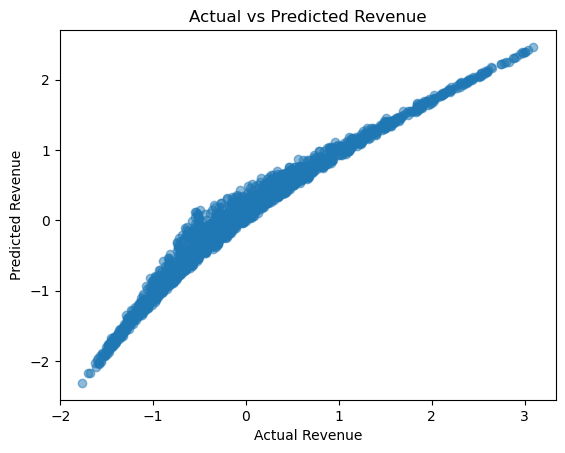

In [29]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

Such a scatterplot means that our model have a completely wrong, albeit consistent, behavior: on the samples which have some "smaller" revenue, less than some breakpoint around 0.61 M, it consistently returns the same small prediction. After that breakpoint, for all the samples it returns the same, a lot larger revenue.

This is essentially a classifier.

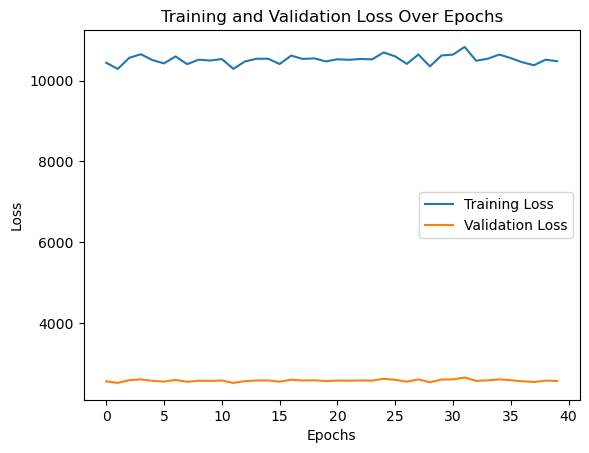

In [30]:
# Plot the evolution of the training and validation errors
train_loss, val_loss = nn.loss_epochs()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Intermediate Conclusions

Clearly, the model encoded in the NeuralNet.py doesn't actually learn. It can indicate either that we have a bug in the implementation of the backpropagation mechanism, or the dataset is fatally incompatible with the fully online backpropagation algorithm, and the errors must be processed from whole batches of training samples instead of the ones picked one-by-one.

## Hyperparameter comparison and selection

Nevertheless, let's perform a bit more comprehensive exploration of the neural network parameters space. Let's compact the above process into a single function so we can pass the neural network parameters and get the three error metrics in one go.

In [31]:
def evaluate(layers=layers, epochs=20, learning_rate=0.1, momentum=0.6, activation_function_name='linear', validation_split=0.2, visualize=False):
    nn = NeuralNet(layers=layers, epochs=epochs, learning_rate=learning_rate, momentum=momentum, activation_function_name=activation_function_name, validation_split=validation_split, visualize=None)
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    y_pred = y_pred.reshape(-1, 1)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    if visualize:
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.xlabel('Actual Revenue')
        plt.ylabel('Predicted Revenue')
        plt.title('Actual vs Predicted Revenue')
        plt.show()
        train_loss, val_loss = nn.loss_epochs()
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.show()
    return mse, mae, mape

This function contains an additional parameter `visualize` which, if set, enables plotting the scatterplot and training loss plot. It allows us to call this function a single time with better visualization.

The neural network which we are using is obviously broken beyond repair so there's no need to run it on the large amount of training epochs, so the default of 20 will be enough, but it is still configurable for individual launches.

The rationale behind choosing the variants is as follows.

1. Minimum recommeded learning rate seems to be 0.01 so let's check it. Next we check 0.15 as a "reasonable" value and then 0.5 as "slightly unreasonable"
2. Chose only two variants of momentum to reduce the search space. The logic is the same: 0.1 is a "reasonable" value and 0.5 is "more or less high".
3. Only two activation functions were used, both nonlinear, again, to reduce the search space but still use the "realistic" functions, from the real world.
4. Network configuration 14, 14, 14 is a "straightforward" one, we have 14 inputs and it just propagates them through three hidden layers.
5. Network configuration 5, 7 is an attempt to use just two hidden layers while aggressively reducing the amount of inputs
6. Network configuration 14, 7, 3 is a variant of the previous configuration, which also reduces the amount of inputs gradually, but through three hidden layers.

Network layer configurations has been chosen by guesswork strictly.

In [33]:
import pandas as pd

# Define the parameters to test
learning_rates = [0.01, 0.05, 0.1]
momentums = [0.1, 0.3, 0.5]
activation_functions = ['relu', 'linear']
layer_variants = [
    [input_layer, 28, 6, 1],
    [input_layer, 5, 7, 1],
    [input_layer, 14, 7, 3, 1]
]

# Initialize a list to store the results
results = []

# Iterate over all combinations of parameters
for lr in learning_rates:
    for momentum in momentums:
        for activation_function in activation_functions:
            for layers in layer_variants:
                print(f"Evaluating model with layers: {layers}, learning rate: {lr}, momentum: {momentum}, activation function: {activation_function}")
                mse, mae, mape = evaluate(layers=layers, learning_rate=lr, momentum=momentum, activation_function_name=activation_function)
                results.append({
                    'Layers': layers,
                    'Epochs': 20,
                    'Learning Rate': lr,
                    'Momentum': momentum,
                    'Activation Function': activation_function,
                    'MSE': mse,
                    'MAE': mae,
                    'MAPE': mape
                })
                print(f"Results: MSE: {mse}, MAE: {mae}, MAPE: {mape}%")

# Convert the results to a DataFrame for pretty-printing
results_df = pd.DataFrame(results)
print(results_df)

Evaluating model with layers: [14, 28, 6, 1], learning rate: 0.01, momentum: 0.1, activation function: relu
Epoch 1/20, Training Error: 5377.759318374921, Validation Error: 1312.129362144459
Epoch 2/20, Training Error: 5377.759318374921, Validation Error: 1312.129362144459
Epoch 3/20, Training Error: 5377.759318374921, Validation Error: 1312.129362144459
Epoch 4/20, Training Error: 5377.759318374921, Validation Error: 1312.129362144459
Epoch 5/20, Training Error: 5377.759318374921, Validation Error: 1312.129362144459
Epoch 6/20, Training Error: 5377.759318374921, Validation Error: 1312.129362144459
Epoch 7/20, Training Error: 5377.759318374921, Validation Error: 1312.129362144459
Epoch 8/20, Training Error: 5377.759318374921, Validation Error: 1312.129362144459
Epoch 9/20, Training Error: 5377.759318374921, Validation Error: 1312.129362144459
Epoch 10/20, Training Error: 5377.759318374921, Validation Error: 1312.129362144459
Epoch 11/20, Training Error: 5377.759318374921, Validation Er

ValueError: Input contains NaN.

In the case the above output would be mangled or lost for some reason, here is the resulting table in Markdown:

| Index | Layers              | Epochs | Learning Rate | Momentum | Activation Function | MSE           | MAE            | MAPE       |
|-------|---------------------|--------|---------------|----------|---------------------|---------------|----------------|------------|
| 0     | [14, 14, 14, 14, 1] | 20     | 0.01          | 0.1      | tanh                | 5.259633e+10  | 177267.368911  | 25.448871  |
| 1     | [14, 5, 7, 1]       | 20     | 0.01          | 0.1      | tanh                | 1.315127e+11  | 320211.896492  | 69.415629  |
| 2     | [14, 14, 7, 3, 1]   | 20     | 0.01          | 0.1      | tanh                | 9.957353e+10  | 241771.604336  | 32.143709  |
| 3     | [14, 14, 14, 14, 1] | 20     | 0.01          | 0.1      | sigmoid             | 6.669846e+10  | 230255.001054  | 46.234970  |
| 4     | [14, 5, 7, 1]       | 20     | 0.01          | 0.1      | sigmoid             | 6.594460e+10  | 228682.186867  | 45.946410  |
| 5     | [14, 14, 7, 3, 1]   | 20     | 0.01          | 0.1      | sigmoid             | 6.676715e+10  | 230414.736871  | 46.262763  |
| 6     | [14, 14, 14, 14, 1] | 20     | 0.01          | 0.5      | tanh                | 8.252969e+10  | 222603.390332  | 30.205195  |
| 7     | [14, 5, 7, 1]       | 20     | 0.01          | 0.5      | tanh                | 1.023806e+11  | 286091.706771  | 60.811022  |
| 8     | [14, 14, 7, 3, 1]   | 20     | 0.01          | 0.5      | tanh                | 7.005830e+10  | 235717.989938  | 48.303616  |
| 9     | [14, 14, 14, 14, 1] | 20     | 0.01          | 0.5      | sigmoid             | 6.686486e+10  | 230734.208506  | 46.311921  |
| 10    | [14, 5, 7, 1]       | 20     | 0.01          | 0.5      | sigmoid             | 6.594460e+10  | 228682.186867  | 45.946410  |
| 11    | [14, 14, 7, 3, 1]   | 20     | 0.01          | 0.5      | sigmoid             | 6.686486e+10  | 230734.208506  | 46.311921  |
| 12    | [14, 14, 14, 14, 1] | 20     | 0.15          | 0.1      | tanh                | 3.589070e+10  | 152946.486867  | 23.973530  |
| 13    | [14, 5, 7, 1]       | 20     | 0.15          | 0.1      | tanh                | 4.130869e+10  | 162743.165927  | 26.783674  |
| 14    | [14, 14, 7, 3, 1]   | 20     | 0.15          | 0.1      | tanh                | 1.403161e+11  | 285862.415622  | 37.250343  |
| 15    | [14, 14, 14, 14, 1] | 20     | 0.15          | 0.1      | sigmoid             | 6.652291e+10  | 229935.529419  | 46.172148  |
| 16    | [14, 5, 7, 1]       | 20     | 0.15          | 0.1      | sigmoid             | 6.583948e+10  | 228522.451050  | 45.911856  |
| 17    | [14, 14, 7, 3, 1]   | 20     | 0.15          | 0.1      | sigmoid             | 6.686486e+10  | 230734.208506  | 46.311921  |
| 18    | [14, 14, 14, 14, 1] | 20     | 0.15          | 0.5      | tanh                | 4.588534e+10  | 165946.281583  | 24.423740  |
| 19    | [14, 5, 7, 1]       | 20     | 0.15          | 0.5      | tanh                | 1.415603e+11  | 287061.196113  | 37.390665  |
| 20    | [14, 14, 7, 3, 1]   | 20     | 0.15          | 0.5      | tanh                | 8.655368e+10  | 263312.668475  | 55.229896  |
| 21    | [14, 14, 14, 14, 1] | 20     | 0.15          | 0.5      | sigmoid             | 6.676715e+10  | 230414.736871  | 46.262763  |
| 22    | [14, 5, 7, 1]       | 20     | 0.15          | 0.5      | sigmoid             | 6.586494e+10  | 228522.451050  | 45.916853  |
| 23    | [14, 14, 7, 3, 1]   | 20     | 0.15          | 0.5      | sigmoid             | 6.683109e+10  | 230574.472689  | 46.290626  |
| 24    | [14, 14, 14, 14, 1] | 20     | 0.50          | 0.1      | tanh                | 3.616712e+10  | 153463.354456  | 24.045284  |
| 25    | [14, 5, 7, 1]       | 20     | 0.50          | 0.1      | tanh                | 4.170385e+10  | 163816.345411  | 26.779329  |
| 26    | [14, 14, 7, 3, 1]   | 20     | 0.50          | 0.1      | tanh                | 4.253805e+10  | 165262.004142  | 25.687651  |
| 27    | [14, 14, 14, 14, 1] | 20     | 0.50          | 0.1      | sigmoid             | 6.669846e+10  | 230255.001054  | 46.234970  |
| 28    | [14, 5, 7, 1]       | 20     | 0.50          | 0.1      | sigmoid             | 6.594460e+10  | 228682.186867  | 45.946410  |
| 29    | [14, 14, 7, 3, 1]   | 20     | 0.50          | 0.1      | sigmoid             | 6.682060e+10  | 230574.472689  | 46.287391  |
| 30    | [14, 14, 14, 14, 1] | 20     | 0.50          | 0.5      | tanh                | 1.397211e+11  | 285381.836360  | 37.203493  |
| 31    | [14, 5, 7, 1]       | 20     | 0.50          | 0.5      | tanh                | 4.156218e+10  | 163551.404278  | 26.737717  |
| 32    | [14, 14, 7, 3, 1]   | 20     | 0.50          | 0.5      | tanh                | 1.409154e+11  | 286437.253078  | 37.317227  |
| 33    | [14, 14, 14, 14, 1] | 20     | 0.50          | 0.5      | sigmoid             | 6.670518e+10  | 230414.736871  | 46.252355  |
| 34    | [14, 5, 7, 1]       | 20     | 0.50          | 0.5      | sigmoid             | 6.586494e+10  | 228522.451050  | 45.916853  |
| 35    | [14, 14, 7, 3, 1]   | 20     | 0.50          | 0.5      | sigmoid             | 6.674927e+10  | 230414.736871  | 46.258953  |

The same table, but sorted by the MAPE ascending is below. It seems that configuration 12 is at least better than all others.

Interestingly enough, it looks like the $tanh$ function produces better results, and the top 4 are all of the shape `[14, 14, 14, 14, 1]`

| **Index** | **Layers**          | **Epochs** | **Learning Rate** | **Momentum** | **Activation Function** | **MSE**      | **MAE**       | **MAPE**  |
| --------- | ------------------- | ---------- | ----------------- | ------------ | ----------------------- | ------------ | ------------- | --------- |
| 12        | [14, 14, 14, 14, 1] | 20         | 0.15              | 0.1          | tanh                    | 3.589070e+10 | 152946.486867 | 23.973530 |
| 24        | [14, 14, 14, 14, 1] | 20         | 0.50              | 0.1          | tanh                    | 3.616712e+10 | 153463.354456 | 24.045284 |
| 18        | [14, 14, 14, 14, 1] | 20         | 0.15              | 0.5          | tanh                    | 4.588534e+10 | 165946.281583 | 24.423740 |
| 0         | [14, 14, 14, 14, 1] | 20         | 0.01              | 0.1          | tanh                    | 5.259633e+10 | 177267.368911 | 25.448871 |
| 26        | [14, 14, 7, 3, 1]   | 20         | 0.50              | 0.1          | tanh                    | 4.253805e+10 | 165262.004142 | 25.687651 |
| 31        | [14, 5, 7, 1]       | 20         | 0.50              | 0.5          | tanh                    | 4.156218e+10 | 163551.404278 | 26.737717 |
| 25        | [14, 5, 7, 1]       | 20         | 0.50              | 0.1          | tanh                    | 4.170385e+10 | 163816.345411 | 26.779329 |
| 13        | [14, 5, 7, 1]       | 20         | 0.15              | 0.1          | tanh                    | 4.130869e+10 | 162743.165927 | 26.783674 |
| 6         | [14, 14, 14, 14, 1] | 20         | 0.01              | 0.5          | tanh                    | 8.252969e+10 | 222603.390332 | 30.205195 |
| 2         | [14, 14, 7, 3, 1]   | 20         | 0.01              | 0.1          | tanh                    | 9.957353e+10 | 241771.604336 | 32.143709 |
| 30        | [14, 14, 14, 14, 1] | 20         | 0.50              | 0.5          | tanh                    | 1.397211e+11 | 285381.836360 | 37.203493 |
| 14        | [14, 14, 7, 3, 1]   | 20         | 0.15              | 0.1          | tanh                    | 1.403161e+11 | 285862.415622 | 37.250343 |
| 32        | [14, 14, 7, 3, 1]   | 20         | 0.50              | 0.5          | tanh                    | 1.409154e+11 | 286437.253078 | 37.317227 |
| 19        | [14, 5, 7, 1]       | 20         | 0.15              | 0.5          | tanh                    | 1.415603e+11 | 287061.196113 | 37.390665 |
| 16        | [14, 5, 7, 1]       | 20         | 0.15              | 0.1          | sigmoid                 | 6.583948e+10 | 228522.451050 | 45.911856 |
| 22        | [14, 5, 7, 1]       | 20         | 0.15              | 0.5          | sigmoid                 | 6.586494e+10 | 228522.451050 | 45.916853 |
| 34        | [14, 5, 7, 1]       | 20         | 0.50              | 0.5          | sigmoid                 | 6.586494e+10 | 228522.451050 | 45.916853 |
| 4         | [14, 5, 7, 1]       | 20         | 0.01              | 0.1          | sigmoid                 | 6.594460e+10 | 228682.186867 | 45.946410 |
| 10        | [14, 5, 7, 1]       | 20         | 0.01              | 0.5          | sigmoid                 | 6.594460e+10 | 228682.186867 | 45.946410 |
| 28        | [14, 5, 7, 1]       | 20         | 0.50              | 0.1          | sigmoid                 | 6.594460e+10 | 228682.186867 | 45.946410 |
| 15        | [14, 14, 14, 14, 1] | 20         | 0.15              | 0.1          | sigmoid                 | 6.652291e+10 | 229935.529419 | 46.172148 |
| 3         | [14, 14, 14, 14, 1] | 20         | 0.01              | 0.1          | sigmoid                 | 6.669846e+10 | 230255.001054 | 46.234970 |
| 27        | [14, 14, 14, 14, 1] | 20         | 0.50              | 0.1          | sigmoid                 | 6.669846e+10 | 230255.001054 | 46.234970 |
| 33        | [14, 14, 14, 14, 1] | 20         | 0.50              | 0.5          | sigmoid                 | 6.670518e+10 | 230414.736871 | 46.252355 |
| 35        | [14, 14, 7, 3, 1]   | 20         | 0.50              | 0.5          | sigmoid                 | 6.674927e+10 | 230414.736871 | 46.258953 |
| 5         | [14, 14, 7, 3, 1]   | 20         | 0.01              | 0.1          | sigmoid                 | 6.676715e+10 | 230414.736871 | 46.262763 |
| 21        | [14, 14, 14, 14, 1] | 20         | 0.15              | 0.5          | sigmoid                 | 6.676715e+10 | 230414.736871 | 46.262763 |
| 29        | [14, 14, 7, 3, 1]   | 20         | 0.50              | 0.1          | sigmoid                 | 6.682060e+10 | 230574.472689 | 46.287391 |
| 23        | [14, 14, 7, 3, 1]   | 20         | 0.15              | 0.5          | sigmoid                 | 6.683109e+10 | 230574.472689 | 46.290626 |
| 9         | [14, 14, 14, 14, 1] | 20         | 0.01              | 0.5          | sigmoid                 | 6.686486e+10 | 230734.208506 | 46.311921 |
| 11        | [14, 14, 7, 3, 1]   | 20         | 0.01              | 0.5          | sigmoid                 | 6.686486e+10 | 230734.208506 | 46.311921 |
| 17        | [14, 14, 7, 3, 1]   | 20         | 0.15              | 0.1          | sigmoid                 | 6.686486e+10 | 230734.208506 | 46.311921 |
| 8         | [14, 14, 7, 3, 1]   | 20         | 0.01              | 0.5          | tanh                    | 7.005830e+10 | 235717.989938 | 48.303616 |
| 20        | [14, 14, 7, 3, 1]   | 20         | 0.15              | 0.5          | tanh                    | 8.655368e+10 | 263312.668475 | 55.229896 |
| 7         | [14, 5, 7, 1]       | 20         | 0.01              | 0.5          | tanh                    | 1.023806e+11 | 286091.706771 | 60.811022 |
| 1         | [14, 5, 7, 1]       | 20         | 0.01              | 0.1          | tanh                    | 1.315127e+11 | 320211.896492 | 69.415629 |

To compare the results, below is the full output for the configuration 12, with scatterplot and training error plots, and for the configuration 1, which is the worst performing in terms of MAPE. Epochs count is 50.

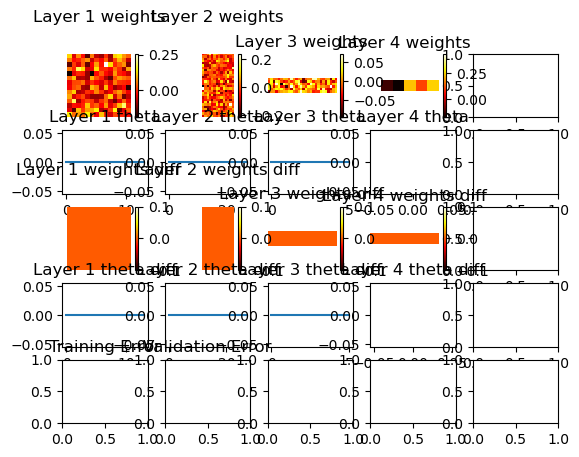

KeyboardInterrupt: 

In [34]:
evaluate(layers=[input_layer, 14, 28, 6, 1], epochs=10, learning_rate=0.01, momentum=0.1, activation_function_name='linear', visualize=True)

evaluate(layers=[input_layer, 5, 7, 1], epochs=50, learning_rate=0.01, momentum=0.1, activation_function_name='tanh', visualize=True)

# Conclusion

Clearly, this model is inadequate.

Judging by its behavior, it's effectively a classifier, emitting either 0 or 1.
Why this happens is a topic of another investigation, most possibly it's because of a mistake in the encoding of the backpropagation calculations in the NeuralNet.py code.

As we see later in the [`03-compare-with.ipynb`](./03-compare-with.ipynb) notebook, Pytorch neural network is able to predict the revenue very well, so it's not the problem of the input data.

There's no value in checking the non-reduced dataset (the one which includes all the variables) until the neural network code will be fixed.

Despite that, this notebook can be used as is for any future evaluation of the NeuralNetwork.py, without any changes.
Potentially, after the code review and correction, this notebook will calculate to different results. This conclusion will be different then.